In [2]:
import gdown

In [3]:
file_id = "1i7hqUUalyRdWGTsZicGwXD31w85JadH2"
gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output="data.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1i7hqUUalyRdWGTsZicGwXD31w85JadH2&confirm=t
To: /content/data.zip
100%|██████████| 314M/314M [00:07<00:00, 42.1MB/s]


'data.zip'

In [4]:
!unzip data.zip -d data

Archive:  data.zip
   creating: data/train/
   creating: data/train/anomalous/
  inflating: data/train/anomalous/section_00_source_test_anomaly_0000.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0001.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0002.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0004.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0007.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0008.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0009.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0010.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0011.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0012.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0013.wav  
  inflating: data/train/anomalous/section_00_source_test_anomaly_0016.wav  
  inflati

In [5]:
import torch
import torchaudio
import random
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from torchaudio.transforms import Resample, PitchShift

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

MODEL_CHECKPOINT = "MIT/ast-finetuned-audioset-10-10-0.4593"
SAMPLE_RATE = 16000     # AST requires 16k
MAX_DURATION = 4.0      # Cut audio to 4 seconds to speed up attention mechanism
BATCH_SIZE = 8          # Higher batch size since we cut audio length
MAX_SAMPLES = 2000

Using device: cpu


In [6]:

# Config
train_path = Path("/content/data/train")
val_path   = Path("/content/data/val")

# 1. Collect Training Files
train_normal = list((train_path/"normal").glob("*.wav"))
train_anomal = list((train_path/"anomalous").glob("*.wav"))

train_files  = train_normal + train_anomal
train_labels = [0] * len(train_normal) + [1] * len(train_anomal)

# 2. Collect Validation Files
val_normal = list((val_path/"normal").glob("*.wav"))
val_anomal = list((val_path/"anomalous").glob("*.wav"))

val_files  = val_normal + val_anomal
val_labels = [0] * len(val_normal) + [1] * len(val_anomal)

print(f"Training Set: {len(train_files)} files")
print(f"Validation Set: {len(val_files)} files")


Training Set: 800 files
Validation Set: 200 files


In [7]:
! pip install librosa

In [18]:
import numpy as np
import random
import librosa
from transformers import ASTFeatureExtractor, AutoModelForAudioClassification

feature_extractor = ASTFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

def augment_audio(y, sr):
    """
    Applies random augmentations to the raw audio waveform.
    Fast numpy operations only (No slow pitch shifting).
    """
    # 1. Add Gaussian White Noise (Simulate factory background noise)
    if random.random() < 0.5:
        noise_amp = 0.005 * np.max(y)
        noise = np.random.randn(len(y)) * noise_amp
        y = y + noise

    # 2. Random Gain/Volume (Simulate distance from microphone)
    if random.random() < 0.5:
        gain = random.uniform(0.8, 1.2)
        y = y * gain

    # 3. Time Shift (Roll audio left/right)
    if random.random() < 0.5:
        shift_amt = int(sr * random.uniform(-0.1, 0.1)) # +/- 100ms
        y = np.roll(y, shift_amt)

    return y

def preprocess_set(paths, labels, augment=False):
    input_list = []
    label_list = []

    print(f"Processing {len(paths)} files... (Augmentation={'ON' if augment else 'OFF'})")

    for i, path in enumerate(paths):
        path_str = str(path)

        try:
            # 1. Load Audio (Crop to 4s)
            audio, _ = librosa.load(path_str, sr=SAMPLE_RATE, duration=MAX_DURATION)

            # 2. Apply Augmentation
            if augment:
                audio = augment_audio(audio, SAMPLE_RATE)

            # 3. Pad/Crop to exact length
            target_len = int(SAMPLE_RATE * MAX_DURATION)
            if len(audio) < target_len:
                audio = np.pad(audio, (0, target_len - len(audio)))
            else:
                audio = audio[:target_len]

            # 4. Extract Spectrogram Features
            inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt")

            input_list.append(inputs["input_values"].squeeze(0))
            label_list.append(labels[i])

        except Exception as e:
            print(f"Error loading {path_str}: {e}")

        if i % 100 == 0 and i > 0: print(f"Processed {i}...")

    return input_list, label_list


# 1. Process Training Data WITH Augmentation
print("--- Processing TRAINING Data (with Noise/Gain Augmentation) ---")
train_X, train_y = preprocess_set(train_files, train_labels, augment=True)

# 2. Process Validation Data WITHOUT Augmentation
print("\n--- Processing VALIDATION Data (Clean) ---")
test_X, test_y = preprocess_set(val_files, val_labels, augment=False)

--- Processing TRAINING Data (with Noise/Gain Augmentation) ---
Processing 800 files... (Augmentation=ON)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...

--- Processing VALIDATION Data (Clean) ---
Processing 200 files... (Augmentation=OFF)
Processed 100...


In [19]:
#checking the number of normal and anomalies sample in train
print(train_y.count(0))
print(train_y.count(1))

400
400


Visualizing Training Sample #0 (Augmented):


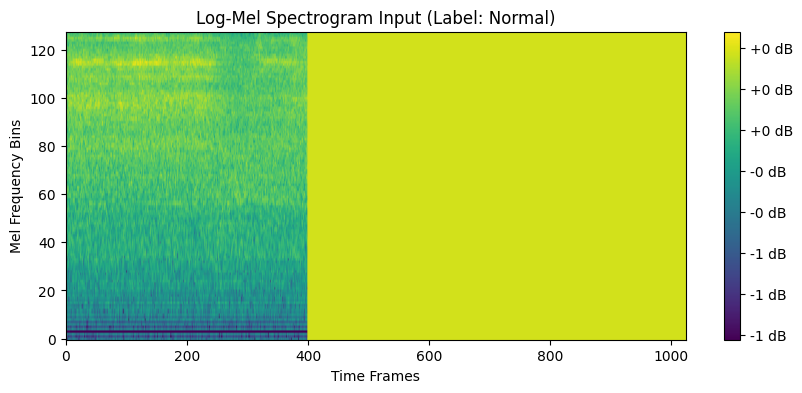

Visualizing Validation Sample #0 (Clean):


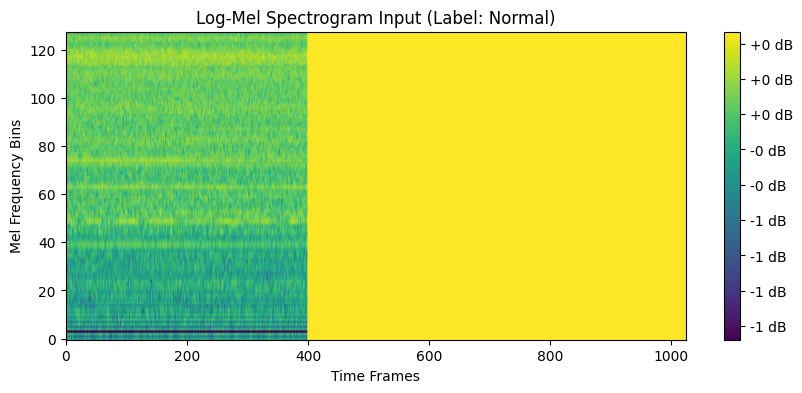

In [20]:
#Verify and Visualize Log-Mel Spectrograms
import matplotlib.pyplot as plt

def plot_log_mel(tensor_data, label_id):

    spectrogram = tensor_data.T.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Log-Mel Spectrogram Input (Label: {'Anomaly' if label_id==1 else 'Normal'})")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Visualize a few samples from our processed lists
print("Visualizing Training Sample #0 (Augmented):")
plot_log_mel(train_X[0], train_y[0])

print("Visualizing Validation Sample #0 (Clean):")
plot_log_mel(test_X[0], test_y[0])

In [21]:
#checking  the shape of the samples
print(train_X[0].shape)
print(test_X[0].shape)

torch.Size([1024, 128])
torch.Size([1024, 128])


In [22]:
#Create Fast Dataset Object
class FastASTDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Trainer expects dictionary with 'input_values' and 'labels'
        return {
            "input_values": self.features[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create objects using the data from Cell 4
train_dataset = FastASTDataset(train_X, train_y)
test_dataset = FastASTDataset(test_X, test_y)


In [25]:
# Load Model & Freeze Body
model = ASTForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,                     # Binary Classification (Normal vs Anomaly)
    ignore_mismatched_sizes=True
)

# Map labels for readability in the UI later
model.config.id2label = {0: "NORMAL", 1: "ANOMALY"}
model.config.label2id = {"NORMAL": 0, "ANOMALY": 1}

# # --- SPEED HACK: FREEZE THE TRANSFORMER ---
# print("Freezing transformer layers to speed up training...")
# for param in model.audio_spectrogram_transformer.parameters():
#     param.requires_grad = False

# # Unfreeze ONLY the classifier (the decision head)
# for param in model.classifier.parameters():
#     param.requires_grad = True

for name, param in model.named_parameters():
    if "patch_embed" in name or "layer.0" in name or "layer.1" in name:
        param.requires_grad = False

print(" Model loaded. Body is FROZEN. Only the head will train.")

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded. Body is FROZEN. Only the head will train.


In [26]:
!pip install evaluate

In [32]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

# Load the metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Configuration
training_args = TrainingArguments(
    output_dir="./ast_turbo_results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=18,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=20,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    disable_tqdm=False,
    dataloader_num_workers=4,
    dataloader_pin_memory=False,
    fp16=False,
    bf16=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [33]:
from transformers import TrainerCallback
from tqdm.auto import tqdm

class TqdmCallback(TrainerCallback):
    def __init__(self):
        self.pbar = None

    def on_train_begin(self, args, state, control, **kwargs):
        total_steps = state.max_steps if state.max_steps != 0 else (
            len(kwargs["train_dataloader"]) * args.num_train_epochs
        )
        self.pbar = tqdm(
            total=total_steps,
            desc="Training",
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} | {elapsed}<{remaining}",
            colour="cyan",
            leave=True
        )

    def on_step_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            # Update progress
            self.pbar.update(1)

            # Show latest metrics
            if state.log_history:
                last_log = state.log_history[-1]
                loss = last_log.get("loss", None)
                lr = last_log.get("learning_rate", None)
                epoch = last_log.get("epoch", state.epoch)

                postfix = {}
                if loss is not None:
                    postfix["loss"] = f"{loss:.4f}"
                if lr is not None:
                    postfix["lr"] = f"{lr:.2e}"
                postfix["epoch"] = f"{epoch:.2f}"

                self.pbar.set_postfix(postfix)

    def on_epoch_end(self, args, state, control, **kwargs):
        if "eval_accuracy" in state.log_history[-1]:
            acc = state.log_history[-1]["eval_accuracy"]
            self.pbar.set_postfix({"eval_acc": f"{acc:.4f}", "best": "✓" if acc == state.best_metric else ""})

    def on_train_end(self, args, state, control, **kwargs):
        if self.pbar:
            self.pbar.close()
        print(f"\nTraining finished! Best eval accuracy: {state.best_metric:.4f}")

# Add it to your existing trainer
trainer.add_callback(TqdmCallback())

In [1]:

trainer.train()

NameError: name 'trainer' is not defined

In [31]:
#  Evaluation + AUC
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

preds = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(preds.predictions), dim=1)[:,1].numpy()
labels = preds.label_ids

auc = roc_auc_score(labels, probs)
print(f"\nROC-AUC on pump  = {auc:.4f} ")

# Classification report
print(classification_report(labels, (probs > 0.5).astype(int), target_names=["Normal", "Anomaly"]))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



ROC-AUC on pump  = 0.7750 
              precision    recall  f1-score   support

      Normal       0.67      0.74      0.70       100
     Anomaly       0.71      0.64      0.67       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200



In [ ]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from sklearn.metrics import roc_auc_score

# Load the metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    labels = eval_pred.label_ids

    # Calculate accuracy
    accuracy = accuracy_metric.compute(predictions=np.argmax(predictions, axis=1), references=labels)

    # Calculate ROC-AUC

    probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=-1, keepdims=True)
    roc_auc = roc_auc_score(labels, probabilities[:, 1])

    return {"accuracy": accuracy["accuracy"], "roc_auc": roc_auc}

# Configuration
training_args = TrainingArguments(
    output_dir="./ast_turbo_results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=False,
    metric_for_best_model="roc_auc", # Changed to roc_auc
    greater_is_better=True,
    report_to="none",
    disable_tqdm=False,
    dataloader_num_workers=4,
    dataloader_pin_memory=False,
    fp16=False,
    bf16=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.559500,0.402170,0.859524,0.657685


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 